# Working with large virtual chemical libraries: Part 1 - Active Learning

This is part 1 of a a planned three post series on working with large chemical libraries.

Estimates of the size of [chemical space](https://en.wikipedia.org/wiki/Chemical_space) (the number of different molecules that could exist) range from 10<sup>50</sup> - 10<sup>80</sup> possible compounds, with the upper limits approaching estimates of the [total number of atoms in the universe](https://en.wikipedia.org/wiki/Observable_universe) (around 10<sup>80</sup> atoms). It's never going to be possible to make and test every possible chemical compound, even if we limit it to only ["drug-like" compounds](https://en.wikipedia.org/wiki/Druglikeness). Even with fast computational methods it's not always possible to exhaustatively screen virtual libraries. We need methods to find the best scoring compounds from within virtual libraries without scoring every single compound.

Small companies may have hundreds of thousands to millions of physical compounds in their virtual library, and larger companies will have libraries of a few million. Virtual make-on-demand libraries, especially combinatorial libraries, are expanding into the billions of compounds (often called ultra-large libraries). [Enamine REAL](https://enamine.net/compound-collections/real-compounds/real-space-navigator) has 48 billion possible compounds. If your scoring function takes one second per compound, you could maybe screen one million compounds (but it will take 11.6 days), but a billion seconds is nearly 32 years. As the size of virtual libraries expands, it becomes impossible to screen them exhaustively.

There are a range of methods for filtering the library for screening, such as similarity searching or Thompson sampling. In this post I'll dicuss active learning. 

## Active learning

Active learning is a method for searching large libraries when the scoring function that is too computationally expensive to label the full library of compounds. A selection of data is labelled with the expensive scoring function, and a machine learning model is trained on these labels and used to score all compounds from within the library. The compounds with the best scores from the machine learning model are labelled using the more expensive function, and the data from this pooled and used to train a new machine learning model. This cycle is repeated until a finish criteria is met. 

The initial steps are:
1. A random compound is selected as a reference compound.
2. A random sample of the unlabelled data is selected and labelled using the expensive scoring function (Tanimoto similarity).
3. These labelled datapoints are used to train a simple machine learning (random forest) regressor.

Followed the a repeating cycle:

3. The regressor is used to score the entire library
4. The compounds with the highest scores from the machine learning regressor are labelled using the expensive scoring function
5. The labels from the expensive scoring function are pooled and the machine learning model is re-trained

## Imports

First we need to import the libraries we will be using.

In [1]:
import gzip
import math
import re
import shutil
import subprocess
from functools import partial
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

## Expensive scoring function

The first function we will define is the expensive scoring function, this will take a list of SMILES and return a list of scores. For this example I'm going to try find the compound from within the library with the lowest calculated Log P. This is actually a very fast calculation and can be done exhaustatively, which means we can confirm if active learning is finding the lowest value.

In [2]:
def calc_logp(smiles: list[str]) -> list[float]:
    """Calculates the logP value for a list of compounds.

    Args:
        smiles (pd.Series): The input molecules.

    Returns:
        np.arary: The scores of the molecules.
    """
    return [Descriptors.MolLogP(Chem.MolFromSmiles(s)) for s in smiles]

## Defining some useful functions

Next we need to define some useful functions for the active learning pipeline.

The first function creates a virtual library by combining three sets of building blocks. The smi files used here were borrowed from [Pat Walters repository on Thompson sampling](https://github.com/PatWalters/TS). The second creates the Morgan fingerprints for all compounds within the library for training the machine learning model, which is trained using the third function. The final function scores the entire library using the machine learning model.

In [3]:
def build_virtual_library() -> pd.DataFrame:
    """Builds a virtual library by coupling building blocks from the input smi files.

    Returns:
        pd.DataFrame: A DataFrame containing the molecular objects and SMILES strings of
        the products.
    """
    try:
        library = pd.read_csv("data/library.csv", index_col="smiles")
        library["mol"] = [Chem.MolFromSmiles(s) for s in tqdm(library.index.to_list())]
    except FileNotFoundError:
        reaction_smarts = "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]"
        bb_types = ["aminobenzoic", "carboxylic_acids", "primary_amines"]
        rxn = AllChem.ReactionFromSmarts(reaction_smarts)

        building_blocks = []
        for bb in bb_types:
            smil = []
            with open(Path(f"data/{bb}_100.smi"), "r") as f:
                for line in f.readlines():
                    smiles, _ = line.split()
                    smil.append(smiles)
            building_blocks.append(smil)

        total_prods = math.prod([len(x) for x in building_blocks])

        product_list = []
        for reagents in tqdm(product(*building_blocks), total=total_prods):
            reagent_mol_list = [Chem.MolFromSmiles(x) for x in reagents]
            products = rxn.RunReactants(reagent_mol_list)
            if products:
                Chem.SanitizeMol(products[0][0])
                product_list.append(products[0][0])

        library = pd.DataFrame(
            product_list,
            index=[Chem.MolToSmiles(m) for m in product_list],
            columns=["mol"],
        )
        library.index.name = "smiles"
        library["slow_scores"] = np.NaN
        library["model_scores"] = np.NaN
        library["scored_round"] = np.NaN
        library.to_csv("data/library.csv")
    return library


def create_morgan_fingerprints(library: pd.DataFrame) -> pd.DataFrame:
    """Creates Morgan fingerprints for the input library.

    Args:
        library (pd.DataFrame): The input library.

    Returns:
        pd.DataFrame: The Morgan fingerprints of the input library.
    """
    try:
        fps_df = pd.read_csv("data/fingerprints.csv").set_index("smiles")
    except FileNotFoundError:
        fps = [
            list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2))
            for mol in tqdm(library.mol)
        ]
        fps_df = pd.DataFrame(
            fps, columns=[f"fp_{x}" for x in range(len(fps[0]))], index=library.index
        )
        fps_df.to_csv("data/fingerprints.csv")
    return fps_df


def train_ml_model(
    library: pd.DataFrame, fingerprints: pd.DataFrame
) -> RandomForestRegressor:
    """Trains a random forest regressor model on slow scores for the input library.

    Args:
        library (pd.DataFrame): The input library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        RandomForestRegressor: The trained random forest regressor model.
    """
    scored = library[~library["slow_scores"].isna()]
    X = fingerprints.loc[scored.index]
    y = scored["slow_scores"]
    regressor = RandomForestRegressor(max_depth=10)
    regressor.fit(X, y)
    return regressor


def score_library(
    library: pd.DataFrame,
    regressor: RandomForestRegressor,
    fingerprints: pd.DataFrame,
) -> pd.DataFrame:
    """Scores the entire library with the trained model.

    Args:
        library (pd.DataFrame): The input library.
        regressor (RandomForestRegressor): The trained random forest regressor model.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.

    Returns:
        pd.DataFrame: The input library with the model scores.
    """
    library["model_scores"] = regressor.predict(fingerprints)
    return library

## Active learning pipeline

We then need to set up the active learning pipeline. This follows the steps from above:

1. A random compound is selected as a reference compound.
2. A random sample of the unlabelled data is selected and labelled using the expensive scoring function (Tanimoto similarity).
3. These labelled datapoints are used to train a simple machine learning (random forest) regressor.

Followed the a repeating cycle:

3. The regressor is used to score the entire library
4. The compounds with the highest scores from the machine learning regressor are labelled using the expensive scoring function
5. The labels from the expensive scoring function are pooled and the machine learning model is re-trained

Because we sometimes know the best value for a scoring function, I've added a early stopping condition if the best compound is found to save time.

In [4]:
def run_active_learning(
    library: pd.DataFrame,
    fingerprints: pd.DataFrame,
    compounds_per_round: int,
    number_of_rounds: int,
    scoring_function: callable,
    minimize: bool,
    early_stopping_value: float | None = None,
) -> pd.DataFrame:
    """Runs active learning on the virtual library.

    Args:
        library (pd.DataFrame): The input virtual library.
        fingerprints (pd.DataFrame): The Morgan fingerprints of the input library.
        compounds_per_round (int): Number of compounds to select per round.
        number_of_rounds (int): Number of active learning rounds.
        scoring_function (callable): The slow scoring function.
        minimize (bool): Whether to minimize or maximize the slow scoring function.
        early_stopping_value (float | None): If the slow scoring function finds a
        compound with this value, stops the active learning.

    Returns:
        pd.DataFrame: The input library with the slow scores added.
    """
    # Select initial random sample
    initial_sample = library.sample(compounds_per_round)
    library["slow_scores"] = np.NaN

    # Score the initial sample
    initial_scores = scoring_function(initial_sample.index.to_list())

    # Save the slow scores
    library.loc[initial_sample.index, "slow_scores"] = initial_scores

    # Run active learning
    al_round = 0
    while al_round < number_of_rounds:
        # Train the ML model
        model = train_ml_model(library, fingerprints)

        # Use the model to score the entire virtual library
        library = score_library(library, model, fingerprints)

        # Select the top scoring molecules with no slow scores
        top_compounds = (
            library[library["slow_scores"].isna()]
            .sort_values("slow_scores", ascending=minimize)
            .head(compounds_per_round)
        )

        # Score the top molecules with the slow function
        slow_scores = scoring_function(top_compounds.index.to_list())
        # Save the slow scores
        library.loc[top_compounds.index, "slow_scores"] = slow_scores
        library.loc[top_compounds.index, "scored_round"] = al_round

        al_round += 1
        if early_stopping_value is not None:
            if minimize:
                if library["slow_scores"].min() == early_stopping_value:
                    break
            else:
                if library["slow_scores"].max() == early_stopping_value:
                    break

    return library

## Example 1: Finding the compound with the lowest cLogP

[Calculated LogP (cLogP)](https://en.wikipedia.org/wiki/Partition_coefficient) is an important property in drug discovery. Whilst we wouldn't usually be aiming to find the minimum or maximum value in a library, it's a useful example as it can be calculated quickly enough to exhaustively screen the library to confirm we're finding the best compound. In the example below, two compounds are randomly selected from the library and their Morgan fingerprints and cLogP values are used to train a machine learning model. This model scores the entire library and the cLogP for two best scoring compounds are pooled with the earlier compounds and the process repeated. After only six rounds (12 compounds scored), the active learning algorithm is able to find the lowest cLogP in the library, much quicker than exhaustatively screening all 132,500 compounds! The experiment was repeated ten times and the number of compounded needed is constant across the repeats. cLogP is a simple property, but it's still impressive how little data the machine learning model neededs to find the best scores.

In [5]:
# Active learning parameters
COMPOUNDS_PER_ROUND = 2
NUMBER_OF_ROUNDS = 50
MINIMIZE = True
NUMBER_OF_REPEATS = 10

# Create the virtual library
print("Creating virtual library")
library = build_virtual_library()

# Create morgan fingerprints for the library
print("Creating Morgan fingerprints")
fingerprints = create_morgan_fingerprints(library)

# Find the minimum logP in the library
all_clogp_values = calc_logp(library.index.to_list())
print(f"Minimum logP in the library: {min(all_clogp_values):.2f}")

# Run active learning
print("Running active learning")
scored_compounds_per_run = []
for i in tqdm(range(NUMBER_OF_REPEATS)):
    # Reset library between rounds
    library["slow_scores"] = np.NaN
    library["model_scores"] = np.NaN
    library["scored_round"] = np.NaN

    # Active learning
    library = run_active_learning(
        library=library,
        fingerprints=fingerprints,
        compounds_per_round=COMPOUNDS_PER_ROUND,
        number_of_rounds=NUMBER_OF_ROUNDS,
        scoring_function=calc_logp,
        minimize=MINIMIZE,
        early_stopping_value=min(all_clogp_values),
    )

    # Log results
    scored_compounds_per_run.append(len(library.loc[library.slow_scores.notna()]))

ave_scored_compounds = np.mean(scored_compounds_per_run) - COMPOUNDS_PER_ROUND
print(
    f"Average number of scored compounds before finding lowest value: {ave_scored_compounds:.2f}"
)

Creating virtual library


100%|██████████| 1000000/1000000 [01:42<00:00, 9747.08it/s]


Creating Morgan fingerprints


100%|██████████| 132500/132500 [04:11<00:00, 526.70it/s]


Minimum logP in the library: -5.00
Running active learning


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

Average number of scored compounds before finding lowest value: 12.00


## Example 2: Recovering a random compounds from within the library using Tanimoto similarity

[Molecular similarity](https://en.wikipedia.org/wiki/Chemical_similarity) is often defined as the [Tanimoto similarity](https://en.wikipedia.org/wiki/Jaccard_index) between Morgan fingerprints. In the next experiment we'll try to maximise the Tanimoto similarity to a reference molecule. The reference molecule will be randomly selected from the library, so the maximum similarity will be 1. This turned out to be a siginificantly more difficult problem than the previous example minimizing cLogP. The number of compounds per round and number of rounded were increased (5000 compounds screened), and even still the reference molecule was only recovered once out of the ten repeats. This was a slightly surprising result considering the machine learning models were trained using the Morgan fingerprints that were also used in the Tanimoto similarity.

In [7]:
def calc_similarity(comparison_smiles: list[str], ref_smiles: str) -> list[float]:
    """Calculates the Tanimoto similarity of a reference compound to a list of
    comparison compounds.

    Args:
        comparison_smiles (list[str]): List of SMILES to compare to
        ref_smiles (str): SMILES of the reference compound

    Returns:
        list[float]: List of similarity scores
    """
    ref_mol = Chem.MolFromSmiles(ref_smiles)
    comparison_mols = [Chem.MolFromSmiles(x) for x in comparison_smiles]
    fpgen = AllChem.GetMorganGenerator()
    ref_fp = fpgen.GetFingerprint(ref_mol)
    comparison_fps = [fpgen.GetFingerprint(x) for x in comparison_mols]
    return [DataStructs.FingerprintSimilarity(ref_fp, x) for x in comparison_fps]


# Active learning parameters
COMPOUNDS_PER_ROUND = 100
NUMBER_OF_ROUNDS = 50
MINIMIZE = False
NUMBER_OF_REPEATS = 10

# Run active learning
print("Running active learning")
scored_compounds_per_run = []
for i in tqdm(range(NUMBER_OF_REPEATS)):
    # Choose a random reference molecule
    ref_smiles = library.sample(1).index[0]

    # Reset library between rounds
    library["slow_scores"] = np.NaN
    library["model_scores"] = np.NaN
    library["scored_round"] = np.NaN

    # Active learning
    library = run_active_learning(
        library=library,
        fingerprints=fingerprints,
        compounds_per_round=COMPOUNDS_PER_ROUND,
        number_of_rounds=NUMBER_OF_ROUNDS,
        scoring_function=partial(calc_similarity, ref_smiles=ref_smiles),
        minimize=MINIMIZE,
        early_stopping_value=1,
    )

    # Log results
    top = library[~library.slow_scores.isna()].sort_values(
        "slow_scores", ascending=MINIMIZE
    )
    scored_compounds_per_run.append(
        {
            "round": i,
            "reference_molecule": ref_smiles,
            "compounds_scored": len(library[~library.slow_scores.isna()]),
            "top_scorer": top.index.to_list()[0],
            "top_score": top.slow_scores.values[0],
        }
    )

pd.DataFrame(scored_compounds_per_run).set_index("round").style.format(
    {"top_score": "{:.3f}"}
)

Running active learning


100%|██████████| 10/10 [22:30<00:00, 135.02s/it]


,reference_molecule,compounds_scored,top_scorer,top_score
round,,,,
0,COc1ccc2c(=O)n(C(=N)NCC(=O)O)c([C@@H](CN)CO)nc2c1OC,5100,N=C(NCC(=O)O)n1c([C@H](CN)CO)nc2c(=O)[nH]c(=O)[nH]c2c1=O,0.466
1,CC(=O)OC[C@H](C(=O)O)n1c([C@H](N)CN(C)C)nc2[nH][nH]c(=O)c2c1=O,3300,CC(=O)OC[C@H](C(=O)O)n1c([C@H](N)CN(C)C)nc2[nH][nH]c(=O)c2c1=O,1.000
2,Cc1cc2nc([C@H](C)NC(=O)CN)n(CC[C@H](N)C(=O)O)c(=O)c2cc1O,5100,C[C@H](NC(=O)CN)c1nc2c(c(=O)n1CC[C@H](N)C(=O)O)c(=O)n(C)c(=O)n2C,0.506
3,Nc1nncn1Cc1nc2c(cnc3ccnn32)c(=O)n1C(=O)[C@H](N)CC(=O)O,5100,Cn1c(=O)c2c(=O)n(C(=O)[C@@H](N)CC(=O)O)c(Cn3cnnc3N)nc2n(C)c1=O,0.495
4,Cn1nnc2nc(C3(O)CC(N)C3)n([C@H](CO)C(=O)O)c(=O)c21,5100,Cn1c(=O)c2c(=O)n([C@@H](CO)C(=O)O)c(C3(O)CC(N)C3)nc2n(C)c1=O,0.488
5,Cn1cc2c(=O)n(CC[C@@H](N)C(=O)O)c([C@H](CO)NC(N)=O)nc2n1,5100,Cn1c(=O)c2c(=O)n(CC[C@@H](N)C(=O)O)c([C@H](CO)NC(N)=O)nc2n(C)c1=O,0.518
6,COC(=O)c1ccc2c(=O)n(CC[C@@H](N)C(=O)O)c([C@@H](N)CCO)nc2c1,5100,Cn1c(=O)c2c(=O)n(CC[C@@H](N)C(=O)O)c([C@@H](N)CCO)nc2n(C)c1=O,0.449
7,C[C@H](O)[C@H](N)c1nc2cnc(Cl)nc2c(=O)n1[C@H](C(=O)O)[C@@H](C)O,5100,C[C@H](O)[C@@H](C(=O)O)n1c([C@@H](N)[C@@H](C)O)nc2c(=O)[nH]c(N)nc2c1=O,0.434
8,Cn1cnc2c(=O)n(C(=O)C[C@H](N)C(=O)O)c([C@@H](N)CO)nc21,5100,Cn1c(=O)c2c(=O)n(C(=O)C[C@H](N)C(=O)O)c([C@H](N)CO)nc2n(C)c1=O,0.519


Looking at the final run, we can see that in general the maximum similarity is not increasing significantly with further rounds, apart from the occasional spike as the model finds a similar compound. This suggests that increasing the number of rounds may not increase the performance.

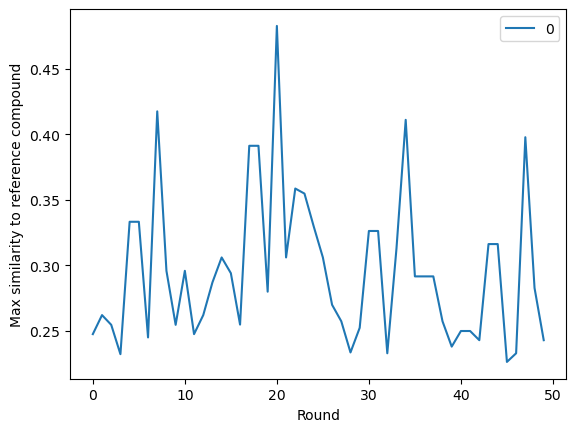

In [31]:
sns.lineplot(
    library[["slow_scores", "scored_round"]].groupby("scored_round").max().values
).set(xlabel="Round", ylabel="Max similarity to reference compound")
plt.show()

## Why does AL work well for cLogP but not for Tanimoto similarity?

AL was very sucessful at finding the lowest cLogP value in a library, but struggled to recover a randomly chosen reference molecule by trying to maximize the Tanimoto similarity. The reason behind this may be due to the underlying distribution of data within the library. By plotting the cLogP values of all compounds within the library, we can see that the data is close to being normally distributed. The machine learning model is able to learn to predict cLogP well from the data it is given. For the Tanimoto similarity, the scores for the whole library of similarity to the reference compound from the final run are plotted, which have a large postive skew. There is lots of data for predicting Tanimoto similarities between 0.1 and 0.4, but very little data for scores above 0.4. So even though the machine learning model is using the same representation as is used to calculate the Tanimoto similarity (Morgan fingerprint), it doesn't have enough information to learn what makes a high score.

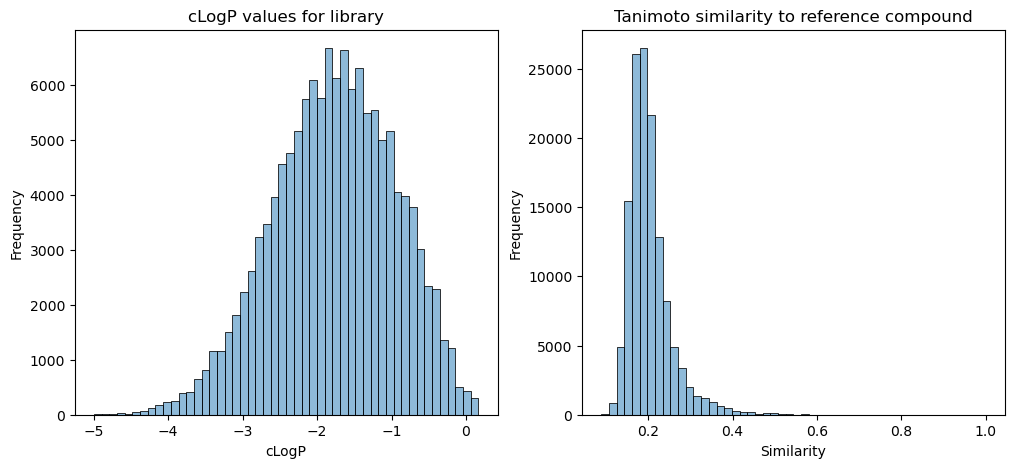

In [9]:
all_similarities = calc_similarity(library.index.to_list(), ref_smiles)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(all_clogp_values, bins=50, alpha=0.5, label="True scores", ax=ax[0])
ax[0].set(title="cLogP values for library", xlabel="cLogP", ylabel="Frequency")
sns.histplot(all_similarities, bins=50, alpha=0.5, label="Predicted scores", ax=ax[1])
ax[1].set(
    title="Tanimoto similarity to reference compound",
    xlabel="Similarity",
    ylabel="Frequency",
)
plt.show()

## Example 3: Docking using SMINA

In [8]:
# Active learning parameters
COMPOUNDS_PER_ROUND = 2
NUMBER_OF_ROUNDS = 50
MINIMIZE = True
NUMBER_OF_REPEATS = 10

# Create the virtual library
print("Creating virtual library")
library = build_virtual_library()

# Create morgan fingerprints for the library
print("Creating Morgan fingerprints")
fingerprints = create_morgan_fingerprints(library)

Creating virtual library


100%|██████████| 132500/132500 [00:09<00:00, 14089.50it/s]


Creating Morgan fingerprints


Running active learning


100%|██████████| 3/3 [4:54:58<00:00, 5899.39s/it]  

Average lowest docking score after screening 50 compounds: -9.14


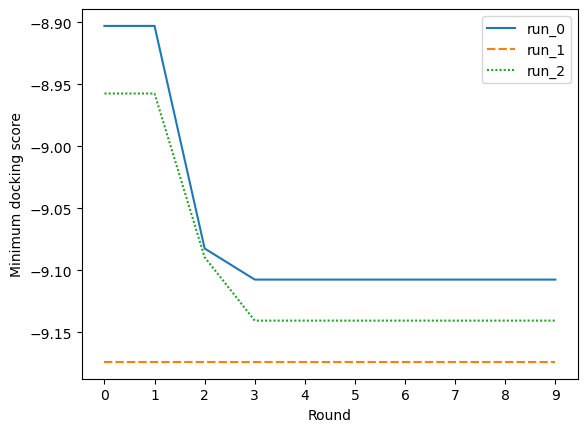

In [9]:
def dock_mols(smiles: list[str]) -> list[float]:
    """Dock the molecules to the SARS MPro protein and return the affinity of the best
    pose for each.

    Args:
        smiles: list[str]: The molecules to dock

    Returns:
        list[float]: The affinities of the best pose for each input molecule
    """
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    scores = []

    for mol in mols:
        with Chem.SDWriter("data/docking/tmp_conf.sdf") as w:
            m = Chem.AddHs(mol)
            _ = AllChem.EmbedMultipleConfs(m, numConfs=5, numThreads=0)
            confs = m.GetConformers()
            for c in confs:
                w.write(m, confId=c.GetId())

        subprocess.run(
            [
                "./smina.osx.12",
                "--exhaustiveness",
                "10",
                "--cpu",
                "10",
                "--seed",
                "0",
                "--autobox_ligand",
                "data/docking/ligand_only.pdb",
                "-r",
                "data/docking/protein_minus_ligand.pdb",
                "-l",
                "data/docking/tmp_conf.sdf",
                "-o",
                "data/docking/tmp_conf_docked.sdf.gz",
            ],
            check=True,
            stdout=subprocess.DEVNULL,
        )

        with gzip.open("data/docking/tmp_conf_docked.sdf.gz", "rb") as f_in:
            with open("data/docking/tmp_conf_docked.sdf", "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        # The output sdf wasn't loading so this is a workaround
        with open("data/docking/tmp_conf_docked.sdf", "r") as f:
            text = f.read()
        affinities = re.findall(r"<minimizedAffinity>\n(-\d.\d+)", text)
        affinities = [float(x) for x in affinities]

        scores.append(min(affinities))

    return scores


# Active learning parameters
COMPOUNDS_PER_ROUND = 5
NUMBER_OF_ROUNDS = 10
MINIMIZE = True
NUMBER_OF_REPEATS = 3

# Run active learning
print("Running active learning")
scored_compounds_per_run = []
cumulative_scores = {}
for i in tqdm(range(NUMBER_OF_REPEATS)):
    # Reset library between rounds
    library["slow_scores"] = np.NaN
    library["model_scores"] = np.NaN
    library["scored_round"] = np.NaN

    # Active learning
    library = run_active_learning(
        library=library,
        fingerprints=fingerprints,
        compounds_per_round=COMPOUNDS_PER_ROUND,
        number_of_rounds=NUMBER_OF_ROUNDS,
        scoring_function=dock_mols,
        minimize=MINIMIZE,
    )

    # Log results
    top = library[~library.slow_scores.isna()].sort_values(
        "slow_scores", ascending=MINIMIZE
    )
    scored_compounds_per_run.append(library.slow_scores.min())
    cumulative_scores[f"run_{i}"] = [
        library[library.scored_round <= j].slow_scores.min()
        for j in range(NUMBER_OF_ROUNDS)
    ]

print(
    f"Average lowest docking score after screening {COMPOUNDS_PER_ROUND * NUMBER_OF_ROUNDS} compounds: {sum(scored_compounds_per_run) / len(scored_compounds_per_run):.2f}"
)

# Plot the cumulative best score found in each round for the final run
sns.lineplot(cumulative_scores).set(
    xlabel="Round", ylabel="Minimum docking score", xticks=range(NUMBER_OF_ROUNDS)
)
plt.show()

## Summary

### Advantages of AL
* Much faster than exhaustive searching.

### Disadvantages
* Requires enumerated library.
* For ultra-large libraries, even scoring the entire library with the ML function may be too expensive.